In [1]:
#Yudha Rizqia Grafer//@ydhrizqi._
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
MAX_SEQUENCE_LENGTH = 5000
MAX_NUM_WORDS = 25000
EMBEDDING_DIM = 64
TEST_SPLIT = 0.3

TEXT_DATA = 'dataset.csv'

In [3]:
# define a function that allows us to evaluate our models

from sklearn.metrics import accuracy_score

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing errors are reported
    '''
    # training error
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)

    # testing error
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)

    return train_acc, test_acc

In [4]:
# estimate 95% confidence interval on error

# NOTE: based on conversation on stackexchange:
# https://stats.stackexchange.com/questions/247551/how-to-determine-the-confidence-of-a-neural-network-prediction
# towards bottom of the page.

from math import sqrt

def error_conf(error, n):
    term = 1.96*sqrt((error*(1-error))/n)
    lb = error - term
    ub = error + term

    return lb, ub

In [ ]:
# # read in our data and preprocess it

df = pd.read_csv(TEXT_DATA)
# df.drop(labels=['id','title'], axis='columns', inplace=True)
# # only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

df['text'] = df['text'].fillna('')

# # Filter out rows where 'cleaned_text' is an empty string
# mask = df['cleaned_text'].apply(lambda x: isinstance(x, str) and len(x) > 0)
# df = df[mask]

# # Buat mask untuk memilih teks yang bukan NaN dan memiliki panjang lebih dari 0
# mask = df['Text'].apply(lambda x: isinstance(x, str) and len(x) > 0)

# # Terapkan mask untuk menghapus baris yang kosong
# df_cleaned = df[mask].copy()

# # Hapus nilai di kolom lain pada baris yang sama
# df_cleaned.loc[~mask, :] = None

# # Reset index setelah menghapus baris
# df_cleaned.reset_index(drop=True, inplace=True)

# df = df_cleaned

In [ ]:
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
import random
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')



# Synonym Replacement (SR)
def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return new_words

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
            synonyms.add(synonym)
    return list(synonyms)

# Random Insertion (RI)
def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return new_words

def add_word(new_words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)

# Random Swap (RS)
def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)
    return new_words

def swap_word(new_words):
    random_idx_1 = random.randint(0, len(new_words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words)-1)
        counter += 1
        if counter > 3:
            return new_words
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
    return new_words

# Random Deletion (RD)
def random_deletion(words, p):
    if len(words) == 1:
        return words
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]
    return new_words

# Apply EDA to each row in the 'text' column
def apply_eda(text):
    words = text.split()
    augmented_texts = []
    num_augmented_texts = 4  # Number of augmented texts to generate

    for _ in range(num_augmented_texts):
        operation = random.choice(['sr', 'ri', 'rs', 'rd'])
        if operation == 'sr':
            augmented_text = synonym_replacement(words, 1)
        elif operation == 'ri':
            augmented_text = random_insertion(words, 1)
        elif operation == 'rs':
            augmented_text = random_swap(words, 1)
        elif operation == 'rd':
            augmented_text = random_deletion(words, 0.1)
        augmented_texts.append(' '.join(augmented_text))

    return augmented_texts

# Function to clean text
def clean_text(text):
    # Remove non-alphabetical characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize text
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]

    # Apply stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    # Join words back to a single string
    return ' '.join(words)

# Apply EDA and expand the DataFrame
augmented_rows = []
for _, row in df.iterrows():
    augmented_texts = apply_eda(row['text'])
    for text in augmented_texts:
        augmented_rows.append({'text': text, 'label': row['label']})

augmented_df = pd.DataFrame(augmented_rows)

# Clean the augmented data
augmented_df['cleaned_text'] = augmented_df['text'].apply(clean_text)

# Clean the original data
df['cleaned_text'] = df['text'].apply(clean_text)

# Combine original and augmented data
combined_df = pd.concat([df[['cleaned_text', 'label']], augmented_df[['cleaned_text', 'label']]], ignore_index=True)

# Save the cleaned and augmented DataFrame to a new CSV file
combined_df.to_csv('augmented_dataset.csv', index=False)

print("Data cleaning and augmentation completed and saved to 'augmented_dataset.csv'.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Data cleaning and augmentation completed and saved to 'augmented_dataset.csv'.


In [ ]:
TEXT_DATA = 'augmented_dataset.csv'

df = pd.read_csv(TEXT_DATA)
mask = df['cleaned_text'].apply(lambda x: isinstance(x, str) and len(x) > 0)
df = df[mask]

In [ ]:
# prepare text samples and their labels

texts = df['cleaned_text']
labels = df['label']


print('Found %s texts.' %texts.shape[0])

Found 34565 texts.


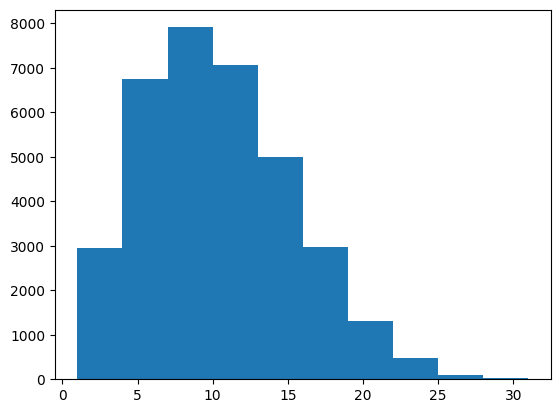

In [ ]:
# plot the distribution of article lengths in terms of word counts

text_lengths = texts.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

## Lexicon Based with EDA

In [ ]:
TEXT_DATA = 'augmented_dataset.csv'

df = pd.read_csv(TEXT_DATA)
mask = df['cleaned_text'].apply(lambda x: isinstance(x, str) and len(x) > 0)
df = df[mask]

# prepare text samples and their labels

texts = df['cleaned_text']
labels = df['label']


print('Found %s texts.' %texts.shape[0])

Found 34572 texts.


In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

# Fungsi untuk mendapatkan skor sentimen VADER dan mengubah label
def get_vader_sentiment(text):
    sentiment = sid.polarity_scores(text)
    # Jika compound > 0, label positive; jika <= 0, label negative
    label = 1 if sentiment['compound'] > 0 else 0
    return sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound'], label

# Terapkan fungsi ke setiap teks di list
lexicon_features = [get_vader_sentiment(text) for text in texts]

# Buat DataFrame dari hasil ekstraksi fitur leksikon
df_lexicon = pd.DataFrame(lexicon_features, columns=['neg', 'neu', 'pos', 'compound', 'label'])


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
print(df_lexicon['label'])

0        0
1        0
2        0
3        1
4        0
        ..
34567    0
34568    0
34569    0
34570    0
34571    0
Name: label, Length: 34572, dtype: int64


In [ ]:
labels = df_lexicon['label']

# vectorize the text samples into a 2D integer tensor

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
data = pad_sequences(sequences,
                     maxlen=MAX_SEQUENCE_LENGTH,
                     padding='pre',
                     truncating='pre')
print(num_words)
print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

11011
Found 11010 unique tokens.
Shape of data tensor: (34572, 5000)
Shape of label tensor: (34572,)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(data,
                                                  labels,
                                                  test_size=TEST_SPLIT)

In [ ]:
# build a 1D convnet with global maxpooling

from keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout

model = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(num_words,
                         EMBEDDING_DIM,
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True),
        layers.Bidirectional(LSTM(64, return_sequences=True)),
        layers.Dropout(0.5),
        layers.Bidirectional(LSTM(32)),
        layers.Dropout(0.5),
        layers.Dense(20, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 64)          704704    
                                                                 
 bidirectional (Bidirection  (None, 5000, 128)         66048     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 5000, 128)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 20)                1

In [ ]:
# train the model

history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
757/757 [==============================] - 483s 625ms/step - loss: 0.2826 - accuracy: 0.8738 - val_loss: 0.1316 - val_accuracy: 0.9590
Epoch 2/10
757/757 [==============================] - 451s 596ms/step - loss: 0.0766 - accuracy: 0.9779 - val_loss: 0.0906 - val_accuracy: 0.9741
Epoch 3/10
757/757 [==============================] - 446s 590ms/step - loss: 0.0442 - accuracy: 0.9867 - val_loss: 0.0738 - val_accuracy: 0.9781
Epoch 4/10
757/757 [==============================] - 448s 591ms/step - loss: 0.0264 - accuracy: 0.9919 - val_loss: 0.0784 - val_accuracy: 0.9813
Epoch 5/10
757/757 [==============================] - 446s 590ms/step - loss: 0.0193 - accuracy: 0.9935 - val_loss: 0.0759 - val_accuracy: 0.9816
Epoch 6/10
757/757 [==============================] - 448s 592ms/step - loss: 0.0124 - accuracy: 0.9956 - val_loss: 0.0935 - val_accuracy: 0.9819
Epoch 7/10
757/757 [==============================] - 448s 591ms/step - loss: 0.0113 - accuracy: 0.9959 - val_loss: 0.0884 -

In [ ]:
# # Predict on validation set
y_pred = model.predict(x_val)
y_pred = (y_pred > 0.5).astype(int).flatten()  # Mengonversi probabilitas menjadi label biner dan memastikannya 1D

# Ambil indeks dari x_val
val_indices = x_val.index if hasattr(x_val, 'index') else range(len(x_val))

# Pastikan labels memiliki indeks yang benar
labels = df['label']

# Buat DataFrame perbandingan
comparison_df = pd.DataFrame({'true_label': labels.iloc[val_indices].values, 'pred_label': y_pred})

# Menghitung persentase prediksi benar
correct_predictions = (comparison_df['true_label'] == comparison_df['pred_label']).sum()
total_predictions = len(comparison_df)
accuracy = correct_predictions / total_predictions * 100

print(f"Persentase prediksi benar: {accuracy:.2f}%")

325/325 [==============================] - 71s 219ms/step
Persentase prediksi benar: 50.06%


## CV and TF_IDF, Bigram with EDA


In [ ]:
TEXT_DATA = 'augmented_dataset.csv'

df = pd.read_csv(TEXT_DATA)
mask = df['cleaned_text'].apply(lambda x: isinstance(x, str) and len(x) > 0)
df = df[mask]

# prepare text samples and their labels

texts = df['cleaned_text']
labels = df['label']


print('Found %s texts.' %texts.shape[0])

Found 34572 texts.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# Inisialisasi TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, max_df=0.95, min_df=2, ngram_range=(1, 2))

# Transformasi teks menjadi fitur TF-IDF
X_tfidf = tfidf_vectorizer.fit_transform(texts).toarray()

# Bagi data menjadi set pelatihan dan validasi
x_train, x_val, y_train, y_val = train_test_split(X_tfidf,
                                                  labels,
                                                  test_size=TEST_SPLIT)

In [ ]:
print(X_tfidf)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:

from keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout

num_words = X_tfidf.shape[1]  # Jumlah kata setara dengan fitur dari TF-IDF

# Definisi model LSTM
model = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(num_words,
                         EMBEDDING_DIM,
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True),
        layers.Bidirectional(LSTM(64, return_sequences=True)),
        layers.Dropout(0.5),
        layers.Bidirectional(LSTM(32)),
        layers.Dropout(0.5),
        layers.Dense(20, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 64)          320000    
                                                                 
 bidirectional (Bidirection  (None, 5000, 128)         66048     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 5000, 128)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 20)                1

In [ ]:
# train the model

history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
757/757 [==============================] - 600s 778ms/step - loss: 0.6931 - accuracy: 0.5158 - val_loss: 0.6933 - val_accuracy: 0.5230
Epoch 2/10
757/757 [==============================] - 482s 637ms/step - loss: 0.6926 - accuracy: 0.5195 - val_loss: 0.6923 - val_accuracy: 0.5230
Epoch 3/10
757/757 [==============================] - 474s 626ms/step - loss: 0.6925 - accuracy: 0.5202 - val_loss: 0.6921 - val_accuracy: 0.5230
Epoch 4/10
757/757 [==============================] - 474s 626ms/step - loss: 0.6924 - accuracy: 0.5202 - val_loss: 0.6922 - val_accuracy: 0.5230
Epoch 5/10
757/757 [==============================] - 477s 630ms/step - loss: 0.6924 - accuracy: 0.5212 - val_loss: 0.6922 - val_accuracy: 0.5230
Epoch 6/10
757/757 [==============================] - 468s 619ms/step - loss: 0.6924 - accuracy: 0.5208 - val_loss: 0.6921 - val_accuracy: 0.5230
Epoch 7/10
757/757 [==============================] - 474s 627ms/step - loss: 0.6923 - accuracy: 0.5210 - val_loss: 0.6922 -

In [ ]:
# Predict on validation set
y_pred = model.predict(x_val)
y_pred = (y_pred > 0.5).astype(int)  # Mengonversi probabilitas menjadi label biner

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

325/325 [==============================] - 78s 236ms/step
Validation Accuracy: 0.5230


## CV dan TF-IDF, Tri-Gram with EDA

In [ ]:
TEXT_DATA = 'augmented_dataset.csv'

df = pd.read_csv(TEXT_DATA)
mask = df['cleaned_text'].apply(lambda x: isinstance(x, str) and len(x) > 0)
df = df[mask]

# prepare text samples and their labels

texts = df['cleaned_text']
labels = df['label']


print('Found %s texts.' %texts.shape[0])

Found 34572 texts.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# Inisialisasi TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, max_df=0.95, min_df=2, ngram_range=(1, 3))

# Transformasi teks menjadi fitur TF-IDF
X_tfidf = tfidf_vectorizer.fit_transform(texts).toarray()

# Bagi data menjadi set pelatihan dan validasi
x_train, x_val, y_train, y_val = train_test_split(X_tfidf,
                                                  labels,
                                                  test_size=TEST_SPLIT)

In [ ]:

from keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout

num_words = X_tfidf.shape[1]  # Jumlah kata setara dengan fitur dari TF-IDF

# Definisi model LSTM
model = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(num_words,
                         EMBEDDING_DIM,
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True),
        layers.Bidirectional(LSTM(64, return_sequences=True)),
        layers.Dropout(0.5),
        layers.Bidirectional(LSTM(32)),
        layers.Dropout(0.5),
        layers.Dense(20, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 5000, 64)          320000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 5000, 128)         66048     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 5000, 128)         0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 20)               

In [ ]:
# train the model

history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
757/757 [==============================] - 457s 594ms/step - loss: 0.6931 - accuracy: 0.5187 - val_loss: 0.6924 - val_accuracy: 0.5212
Epoch 2/10
757/757 [==============================] - 446s 589ms/step - loss: 0.6926 - accuracy: 0.5215 - val_loss: 0.6923 - val_accuracy: 0.5212
Epoch 3/10
757/757 [==============================] - 448s 591ms/step - loss: 0.6924 - accuracy: 0.5210 - val_loss: 0.6923 - val_accuracy: 0.5212
Epoch 4/10
757/757 [==============================] - 441s 583ms/step - loss: 0.6922 - accuracy: 0.5219 - val_loss: 0.6923 - val_accuracy: 0.5212
Epoch 5/10
757/757 [==============================] - 464s 613ms/step - loss: 0.6925 - accuracy: 0.5221 - val_loss: 0.6923 - val_accuracy: 0.5212
Epoch 6/10
757/757 [==============================] - 468s 619ms/step - loss: 0.6923 - accuracy: 0.5216 - val_loss: 0.6923 - val_accuracy: 0.5212
Epoch 7/10
757/757 [==============================] - 473s 625ms/step - loss: 0.6924 - accuracy: 0.5212 - val_loss: 0.6923 -

In [ ]:
# Predict on validation set
y_pred = model.predict(x_val)
y_pred = (y_pred > 0.5).astype(int)  # Mengonversi probabilitas menjadi label biner

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

325/325 [==============================] - 79s 238ms/step
Validation Accuracy: 0.5212


## Word2Vec DNN with EDA

In [ ]:
TEXT_DATA = 'augmented_dataset.csv'

df = pd.read_csv(TEXT_DATA)
mask = df['cleaned_text'].apply(lambda x: isinstance(x, str) and len(x) > 0)
df = df[mask]

# prepare text samples and their labels

texts = df['cleaned_text']
labels = df['label']


print('Found %s texts.' %texts.shape[0])

Found 34572 texts.


In [ ]:
import gensim.downloader as api

# Load the pre-trained Word2Vec model
model_w2v = api.load("word2vec-google-news-300")

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

def text_to_vector(text, model):
    words = text.split()
    word_vectors = [model_w2v[word] for word in words if word in model_w2v]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(300)

# Transformasi teks menjadi vektor Word2Vec
X_word2vec = np.array([text_to_vector(text, model) for text in texts])

# Reshape input to include timestep dimension
X_word2vec = np.expand_dims(X_word2vec, axis=1)  # Shape will be (samples, 1, 300)

# Bagi data menjadi set pelatihan dan validasi
x_train, x_val, y_train, y_val = train_test_split(X_word2vec,
                                                  labels,
                                                  test_size=TEST_SPLIT)

In [ ]:
print(X_word2vec)

[[ 0.10950089  0.06551361  0.03105164 ... -0.06450653 -0.04360962
   0.03709412]
 [-0.01240412  0.0085729  -0.03882344 ...  0.03937276 -0.05004501
   0.05314128]
 [ 0.09446716  0.04914856  0.04529095 ... -0.03196645 -0.0065155
   0.04518127]
 ...
 [-0.07632446  0.00054932  0.04919434 ... -0.02539062 -0.04977417
  -0.0043335 ]
 [-0.07632446  0.00054932  0.04919434 ... -0.02539062 -0.04977417
  -0.0043335 ]
 [-0.02396647 -0.04125977  0.04410807 ... -0.1110026  -0.03039551
  -0.0715332 ]]


In [ ]:
from keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout


# Define LSTM model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(1, 300))),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(20, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build model
model.build(input_shape=(None, 1, 300))

# Build model
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_22 (Bidirect  (None, 1, 128)            186880    
 ional)                                                          
                                                                 
 dropout_22 (Dropout)        (None, 1, 128)            0         
                                                                 
 bidirectional_23 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 20)                1300      
                                                                 
 dense_23 (Dense)            (None, 1)               

In [ ]:
# train the model

history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
757/757 [==============================] - 20s 12ms/step - loss: 0.5632 - accuracy: 0.7067 - val_loss: 0.5128 - val_accuracy: 0.7519
Epoch 2/10
757/757 [==============================] - 8s 11ms/step - loss: 0.5119 - accuracy: 0.7471 - val_loss: 0.4976 - val_accuracy: 0.7573
Epoch 3/10
757/757 [==============================] - 8s 10ms/step - loss: 0.4956 - accuracy: 0.7557 - val_loss: 0.4870 - val_accuracy: 0.7634
Epoch 4/10
757/757 [==============================] - 8s 11ms/step - loss: 0.4851 - accuracy: 0.7606 - val_loss: 0.4843 - val_accuracy: 0.7707
Epoch 5/10
757/757 [==============================] - 8s 11ms/step - loss: 0.4731 - accuracy: 0.7677 - val_loss: 0.4752 - val_accuracy: 0.7724
Epoch 6/10
757/757 [==============================] - 7s 10ms/step - loss: 0.4621 - accuracy: 0.7723 - val_loss: 0.4601 - val_accuracy: 0.7804
Epoch 7/10
757/757 [==============================] - 8s 10ms/step - loss: 0.4506 - accuracy: 0.7774 - val_loss: 0.4494 - val_accuracy: 0.784

In [ ]:
# Predict on validation set
y_pred = model.predict(x_val)
y_pred = (y_pred > 0.5).astype(int)  # Mengonversi probabilitas menjadi label biner

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

325/325 [==============================] - 2s 3ms/step
Validation Accuracy: 0.8124


## FastText DNN with EDA

In [ ]:
TEXT_DATA = 'augmented_dataset.csv'

df = pd.read_csv(TEXT_DATA)
mask = df['cleaned_text'].apply(lambda x: isinstance(x, str) and len(x) > 0)
df = df[mask]

# prepare text samples and their labels

texts = df['cleaned_text']
labels = df['label']


print('Found %s texts.' %texts.shape[0])

Found 34572 texts.


In [ ]:
import gensim.downloader as api

# Load the FastText model
model_fst = api.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

def text_to_vector(text, model):
    words = text.split()
    word_vectors = [model_fst[word] for word in words if word in model_fst]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(300)

# Transformasi teks menjadi vektor Word2Vec
X_fastT = np.array([text_to_vector(text, model_fst) for text in texts])

# Reshape input to include timestep dimension
X_fastT = np.expand_dims(X_fastT, axis=1)  # Shape will be (samples, 1, 300)

# Bagi data menjadi set pelatihan dan validasi
x_train, x_val, y_train, y_val = train_test_split(X_fastT,
                                                  labels,
                                                  test_size=TEST_SPLIT)

In [ ]:
print(X_fastT)

[[[-0.016029   -0.02077311  0.01020111 ...  0.03221222  0.02648128
    0.00495643]]

 [[ 0.00516947 -0.0215895   0.00109633 ...  0.01404043  0.02546367
    0.0166717 ]]

 [[-0.02298148 -0.04577361  0.02517751 ...  0.01859763  0.02254397
   -0.01706745]]

 ...

 [[ 0.00011492 -0.0147848   0.02251914 ... -0.01200712  0.0170596
   -0.02479552]]

 [[ 0.00011492 -0.0147848   0.02251914 ... -0.01200712  0.0170596
   -0.02479552]]

 [[-0.00385868 -0.0041866   0.02648598 ... -0.01238012  0.01481294
   -0.03089488]]]


In [ ]:
from keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout


# Define LSTM model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(1, 300))),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(20, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build model
model.build(input_shape=(None, 1, 300))

# Build model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 128)            186880    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [ ]:
# train the model

history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
757/757 [==============================] - 25s 17ms/step - loss: 0.5865 - accuracy: 0.6842 - val_loss: 0.5271 - val_accuracy: 0.7398
Epoch 2/10
757/757 [==============================] - 10s 14ms/step - loss: 0.5315 - accuracy: 0.7369 - val_loss: 0.5153 - val_accuracy: 0.7487
Epoch 3/10
757/757 [==============================] - 11s 14ms/step - loss: 0.5197 - accuracy: 0.7441 - val_loss: 0.5154 - val_accuracy: 0.7441
Epoch 4/10
757/757 [==============================] - 11s 15ms/step - loss: 0.5101 - accuracy: 0.7477 - val_loss: 0.5030 - val_accuracy: 0.7499
Epoch 5/10
757/757 [==============================] - 12s 15ms/step - loss: 0.5045 - accuracy: 0.7500 - val_loss: 0.4998 - val_accuracy: 0.7529
Epoch 6/10
757/757 [==============================] - 10s 14ms/step - loss: 0.4966 - accuracy: 0.7536 - val_loss: 0.4931 - val_accuracy: 0.7558
Epoch 7/10
757/757 [==============================] - 11s 15ms/step - loss: 0.4951 - accuracy: 0.7548 - val_loss: 0.4931 - val_accuracy:

In [ ]:
# Predict on validation set
y_pred = model.predict(x_val)
y_pred = (y_pred > 0.5).astype(int)  # Mengonversi probabilitas menjadi label biner

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

325/325 [==============================] - 3s 5ms/step
Validation Accuracy: 0.7622


## Lexicon Based

In [5]:
TEXT_DATA = 'dataset.csv'

df = pd.read_csv(TEXT_DATA)
# df.drop(labels=['id','title'], axis='columns', inplace=True)
# # only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

df['text'] = df['text'].fillna('')

# prepare text samples and their labels

texts = df['text']
labels = df['label']


print('Found %s texts.' %texts.shape[0])

Found 6920 texts.


In [6]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

# Fungsi untuk mendapatkan skor sentimen VADER dan mengubah label
def get_vader_sentiment(text):
    sentiment = sid.polarity_scores(text)
    # Jika compound > 0, label positive; jika <= 0, label negative
    label = 1 if sentiment['compound'] > 0 else 0
    return sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound'], label

# Terapkan fungsi ke setiap teks di list
lexicon_features = [get_vader_sentiment(text) for text in texts]

# Buat DataFrame dari hasil ekstraksi fitur leksikon
df_lexicon = pd.DataFrame(lexicon_features, columns=['neg', 'neu', 'pos', 'compound', 'label'])


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [7]:
labels = df_lexicon['label']

# vectorize the text samples into a 2D integer tensor

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
data = pad_sequences(sequences,
                     maxlen=MAX_SEQUENCE_LENGTH,
                     padding='pre',
                     truncating='pre')
print(num_words)
print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

13832
Found 13831 unique tokens.
Shape of data tensor: (6920, 5000)
Shape of label tensor: (6920,)


In [8]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(data,
                                                  labels,
                                                  test_size=TEST_SPLIT)

In [9]:
# build a 1D convnet with global maxpooling

from keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout

model = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(num_words,
                         EMBEDDING_DIM,
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True),
        layers.Bidirectional(LSTM(64, return_sequences=True)),
        layers.Dropout(0.5),
        layers.Bidirectional(LSTM(32)),
        layers.Dropout(0.5),
        layers.Dense(20, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 64)          885248    
                                                                 
 bidirectional (Bidirection  (None, 5000, 128)         66048     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 5000, 128)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 20)                1

In [10]:
# train the model

history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
152/152 [==============================] - 147s 892ms/step - loss: 0.6668 - accuracy: 0.5879 - val_loss: 0.5972 - val_accuracy: 0.7057
Epoch 2/10
152/152 [==============================] - 112s 737ms/step - loss: 0.3934 - accuracy: 0.8328 - val_loss: 0.5388 - val_accuracy: 0.7336
Epoch 3/10
152/152 [==============================] - 119s 783ms/step - loss: 0.1516 - accuracy: 0.9523 - val_loss: 0.7308 - val_accuracy: 0.7433
Epoch 4/10
152/152 [==============================] - 109s 718ms/step - loss: 0.0600 - accuracy: 0.9825 - val_loss: 0.9363 - val_accuracy: 0.7307
Epoch 5/10
152/152 [==============================] - 93s 610ms/step - loss: 0.0427 - accuracy: 0.9880 - val_loss: 1.1820 - val_accuracy: 0.7081
Epoch 6/10
152/152 [==============================] - 92s 605ms/step - loss: 0.0329 - accuracy: 0.9895 - val_loss: 1.3270 - val_accuracy: 0.7250
Epoch 7/10
152/152 [==============================] - 91s 602ms/step - loss: 0.0189 - accuracy: 0.9942 - val_loss: 1.5487 - va

In [11]:
# # Predict on validation set
y_pred = model.predict(x_val)
y_pred = (y_pred > 0.5).astype(int).flatten()  # Mengonversi probabilitas menjadi label biner dan memastikannya 1D

# Ambil indeks dari x_val
val_indices = x_val.index if hasattr(x_val, 'index') else range(len(x_val))

# Pastikan labels memiliki indeks yang benar
labels = df['label']

# Buat DataFrame perbandingan
comparison_df = pd.DataFrame({'true_label': labels.iloc[val_indices].values, 'pred_label': y_pred})

# Menghitung persentase prediksi benar
correct_predictions = (comparison_df['true_label'] == comparison_df['pred_label']).sum()
total_predictions = len(comparison_df)
accuracy = correct_predictions / total_predictions * 100

print(f"Persentase prediksi benar: {accuracy:.2f}%")

65/65 [==============================] - 15s 210ms/step
Persentase prediksi benar: 51.93%


## CV and TF_IDF, Bigram

In [12]:
TEXT_DATA = 'dataset.csv'

df = pd.read_csv(TEXT_DATA)
# df.drop(labels=['id','title'], axis='columns', inplace=True)
# # only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

df['text'] = df['text'].fillna('')

# prepare text samples and their labels

texts = df['text']
labels = df['label']


print('Found %s texts.' %texts.shape[0])

Found 6920 texts.


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# Inisialisasi TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, max_df=0.95, min_df=2, ngram_range=(1, 2))

# Transformasi teks menjadi fitur TF-IDF
X_tfidf = tfidf_vectorizer.fit_transform(texts).toarray()

# Bagi data menjadi set pelatihan dan validasi
x_train, x_val, y_train, y_val = train_test_split(X_tfidf,
                                                  labels,
                                                  test_size=TEST_SPLIT)

In [14]:

from keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout

num_words = X_tfidf.shape[1]  # Jumlah kata setara dengan fitur dari TF-IDF

# Definisi model LSTM
model = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(num_words,
                         EMBEDDING_DIM,
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True),
        layers.Bidirectional(LSTM(64, return_sequences=True)),
        layers.Dropout(0.5),
        layers.Bidirectional(LSTM(32)),
        layers.Dropout(0.5),
        layers.Dense(20, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 5000, 64)          320000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 5000, 128)         66048     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 5000, 128)         0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 20)               

In [15]:
# train the model

history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
152/152 [==============================] - 92s 561ms/step - loss: 0.6937 - accuracy: 0.5109 - val_loss: 0.6930 - val_accuracy: 0.5202
Epoch 2/10
152/152 [==============================] - 90s 593ms/step - loss: 0.6931 - accuracy: 0.5171 - val_loss: 0.6924 - val_accuracy: 0.5202
Epoch 3/10
152/152 [==============================] - 84s 551ms/step - loss: 0.6922 - accuracy: 0.5180 - val_loss: 0.6929 - val_accuracy: 0.5202
Epoch 4/10
152/152 [==============================] - 90s 593ms/step - loss: 0.6924 - accuracy: 0.5231 - val_loss: 0.6925 - val_accuracy: 0.5202
Epoch 5/10
152/152 [==============================] - 90s 595ms/step - loss: 0.6924 - accuracy: 0.5173 - val_loss: 0.6925 - val_accuracy: 0.5202
Epoch 6/10
152/152 [==============================] - 90s 595ms/step - loss: 0.6927 - accuracy: 0.5202 - val_loss: 0.6924 - val_accuracy: 0.5202
Epoch 7/10
152/152 [==============================] - 90s 594ms/step - loss: 0.6927 - accuracy: 0.5163 - val_loss: 0.6926 - val_ac

In [16]:
# Predict on validation set
y_pred = model.predict(x_val)
y_pred = (y_pred > 0.5).astype(int)  # Mengonversi probabilitas menjadi label biner

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

65/65 [==============================] - 15s 205ms/step
Validation Accuracy: 0.5202


## CV and TF_IDF, Tri-gram

In [17]:
TEXT_DATA = 'dataset.csv'

df = pd.read_csv(TEXT_DATA)
# df.drop(labels=['id','title'], axis='columns', inplace=True)
# # only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

df['text'] = df['text'].fillna('')

# prepare text samples and their labels

texts = df['text']
labels = df['label']


print('Found %s texts.' %texts.shape[0])

Found 6920 texts.


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# Inisialisasi TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, max_df=0.95, min_df=2, ngram_range=(1, 3))

# Transformasi teks menjadi fitur TF-IDF
X_tfidf = tfidf_vectorizer.fit_transform(texts).toarray()

# Bagi data menjadi set pelatihan dan validasi
x_train, x_val, y_train, y_val = train_test_split(X_tfidf,
                                                  labels,
                                                  test_size=TEST_SPLIT)

In [19]:

from keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout

num_words = X_tfidf.shape[1]  # Jumlah kata setara dengan fitur dari TF-IDF

# Definisi model LSTM
model = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(num_words,
                         EMBEDDING_DIM,
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True),
        layers.Bidirectional(LSTM(64, return_sequences=True)),
        layers.Dropout(0.5),
        layers.Bidirectional(LSTM(32)),
        layers.Dropout(0.5),
        layers.Dense(20, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 5000, 64)          320000    
                                                                 
 bidirectional_4 (Bidirecti  (None, 5000, 128)         66048     
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 5000, 128)         0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 20)               

In [20]:
# train the model

history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
152/152 [==============================] - 92s 563ms/step - loss: 0.6941 - accuracy: 0.5039 - val_loss: 0.6918 - val_accuracy: 0.5323
Epoch 2/10
152/152 [==============================] - 90s 596ms/step - loss: 0.6937 - accuracy: 0.5056 - val_loss: 0.6915 - val_accuracy: 0.5323
Epoch 3/10
152/152 [==============================] - 91s 596ms/step - loss: 0.6936 - accuracy: 0.5109 - val_loss: 0.6913 - val_accuracy: 0.5323
Epoch 4/10
152/152 [==============================] - 91s 599ms/step - loss: 0.6928 - accuracy: 0.5147 - val_loss: 0.6911 - val_accuracy: 0.5323
Epoch 5/10
152/152 [==============================] - 91s 601ms/step - loss: 0.6931 - accuracy: 0.5167 - val_loss: 0.6912 - val_accuracy: 0.5323
Epoch 6/10
152/152 [==============================] - 91s 601ms/step - loss: 0.6933 - accuracy: 0.5089 - val_loss: 0.6913 - val_accuracy: 0.5323
Epoch 7/10
152/152 [==============================] - 91s 601ms/step - loss: 0.6928 - accuracy: 0.5184 - val_loss: 0.6919 - val_ac

In [21]:
# Predict on validation set
y_pred = model.predict(x_val)
y_pred = (y_pred > 0.5).astype(int)  # Mengonversi probabilitas menjadi label biner

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

65/65 [==============================] - 15s 205ms/step
Validation Accuracy: 0.5323


## Word2Vec DNN

In [22]:
TEXT_DATA = 'dataset.csv'

df = pd.read_csv(TEXT_DATA)
# df.drop(labels=['id','title'], axis='columns', inplace=True)
# # only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

df['text'] = df['text'].fillna('')

# prepare text samples and their labels

texts = df['text']
labels = df['label']


print('Found %s texts.' %texts.shape[0])

Found 6920 texts.


In [23]:
import gensim.downloader as api

# Load the pre-trained Word2Vec model
model_w2v = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [24]:
import numpy as np
from sklearn.model_selection import train_test_split

def text_to_vector(text, model):
    words = text.split()
    word_vectors = [model_w2v[word] for word in words if word in model_w2v]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(300)

# Transformasi teks menjadi vektor Word2Vec
X_word2vec = np.array([text_to_vector(text, model) for text in texts])

# Reshape input to include timestep dimension
X_word2vec = np.expand_dims(X_word2vec, axis=1)  # Shape will be (samples, 1, 300)

# Bagi data menjadi set pelatihan dan validasi
x_train, x_val, y_train, y_val = train_test_split(X_word2vec,
                                                  labels,
                                                  test_size=TEST_SPLIT)

In [25]:
from keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout


# Define LSTM model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(1, 300))),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(20, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build model
model.build(input_shape=(None, 1, 300))

# Build model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (None, 1, 128)            186880    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 1, 128)            0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                1300      
                                                                 
 dense_7 (Dense)             (None, 1)                

In [26]:
# train the model

history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
152/152 [==============================] - 20s 43ms/step - loss: 0.6093 - accuracy: 0.6691 - val_loss: 0.4463 - val_accuracy: 0.7972
Epoch 2/10
152/152 [==============================] - 4s 25ms/step - loss: 0.4487 - accuracy: 0.7888 - val_loss: 0.4107 - val_accuracy: 0.8194
Epoch 3/10
152/152 [==============================] - 4s 24ms/step - loss: 0.4257 - accuracy: 0.8006 - val_loss: 0.4065 - val_accuracy: 0.8170
Epoch 4/10
152/152 [==============================] - 2s 13ms/step - loss: 0.4118 - accuracy: 0.8072 - val_loss: 0.4349 - val_accuracy: 0.8011
Epoch 5/10
152/152 [==============================] - 2s 12ms/step - loss: 0.4092 - accuracy: 0.8134 - val_loss: 0.4118 - val_accuracy: 0.8174
Epoch 6/10
152/152 [==============================] - 2s 12ms/step - loss: 0.3983 - accuracy: 0.8181 - val_loss: 0.4011 - val_accuracy: 0.8242
Epoch 7/10
152/152 [==============================] - 2s 15ms/step - loss: 0.3936 - accuracy: 0.8210 - val_loss: 0.4023 - val_accuracy: 0.821

In [27]:
# Predict on validation set
y_pred = model.predict(x_val)
y_pred = (y_pred > 0.5).astype(int)  # Mengonversi probabilitas menjadi label biner

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

65/65 [==============================] - 2s 4ms/step
Validation Accuracy: 0.8179


## FastText DNN

In [28]:
TEXT_DATA = 'dataset.csv'

df = pd.read_csv(TEXT_DATA)
# df.drop(labels=['id','title'], axis='columns', inplace=True)
# # only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

df['text'] = df['text'].fillna('')

# prepare text samples and their labels

texts = df['text']
labels = df['label']


print('Found %s texts.' %texts.shape[0])

Found 6920 texts.


In [29]:
import gensim.downloader as api

# Load the FastText model
model_fst = api.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


In [30]:
import numpy as np
from sklearn.model_selection import train_test_split

def text_to_vector(text, model):
    words = text.split()
    word_vectors = [model_fst[word] for word in words if word in model_fst]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(300)

# Transformasi teks menjadi vektor Word2Vec
X_fastT = np.array([text_to_vector(text, model_fst) for text in texts])

# Reshape input to include timestep dimension
X_fastT = np.expand_dims(X_fastT, axis=1)  # Shape will be (samples, 1, 300)

# Bagi data menjadi set pelatihan dan validasi
x_train, x_val, y_train, y_val = train_test_split(X_fastT,
                                                  labels,
                                                  test_size=TEST_SPLIT)

In [31]:
from keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout


# Define LSTM model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(1, 300))),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(20, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build model
model.build(input_shape=(None, 1, 300))

# Build model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirecti  (None, 1, 128)            186880    
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 1, 128)            0         
                                                                 
 bidirectional_9 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 20)                1300      
                                                                 
 dense_9 (Dense)             (None, 1)                

In [32]:
# train the model

history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
152/152 [==============================] - 12s 28ms/step - loss: 0.6815 - accuracy: 0.5586 - val_loss: 0.6264 - val_accuracy: 0.6975
Epoch 2/10
152/152 [==============================] - 2s 11ms/step - loss: 0.5175 - accuracy: 0.7457 - val_loss: 0.4795 - val_accuracy: 0.7683
Epoch 3/10
152/152 [==============================] - 2s 12ms/step - loss: 0.4565 - accuracy: 0.7828 - val_loss: 0.4555 - val_accuracy: 0.7905
Epoch 4/10
152/152 [==============================] - 2s 11ms/step - loss: 0.4346 - accuracy: 0.8002 - val_loss: 0.4400 - val_accuracy: 0.7977
Epoch 5/10
152/152 [==============================] - 2s 12ms/step - loss: 0.4233 - accuracy: 0.8051 - val_loss: 0.4439 - val_accuracy: 0.7991
Epoch 6/10
152/152 [==============================] - 2s 11ms/step - loss: 0.4220 - accuracy: 0.8059 - val_loss: 0.4395 - val_accuracy: 0.7943
Epoch 7/10
152/152 [==============================] - 2s 14ms/step - loss: 0.4154 - accuracy: 0.8103 - val_loss: 0.4333 - val_accuracy: 0.803

In [33]:
# Predict on validation set
y_pred = model.predict(x_val)
y_pred = (y_pred > 0.5).astype(int)  # Mengonversi probabilitas menjadi label biner

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

65/65 [==============================] - 3s 6ms/step
Validation Accuracy: 0.8015
